In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
import os
np.random.seed(4345)
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# path for training data and validation data
train = "data/train"
validation = "data/validation"
test = "data/test/images"

In [3]:
# check size of the dataset
train_food = os.listdir(train+'/food/')
train_nonfood = os.listdir(train+'/nonfood/')

val_food = os.listdir(validation+'/food/')
val_nonfood = os.listdir(validation+'/nonfood/')

test_all = os.listdir(test)

print("Train Food category size {}".format(len(train_food)))
print("Train Non Food category size {}".format(len(train_nonfood)))
print("Validation Food category size {}".format(len(val_food)))
print("Validation Non Food category size {}".format(len(val_nonfood)))
print("Test Food category size {}".format(len(test_all)))

Train Food category size 1500
Train Non Food category size 1500
Validation Food category size 500
Validation Non Food category size 500
Test Food category size 1000


In [4]:
def plot_image(path):
    filenames = os.listdir(path)
    sample_idx = np.random.choice(filenames,3)
    fig, axs = plt.subplots(1, 3,figsize=(15, 15))
    pos = 0
    for col in range(3):
        filepath= path + "/"+sample_idx[pos]
        axs[col].imshow(image.load_img(filepath))
        pos = pos + 1
    return

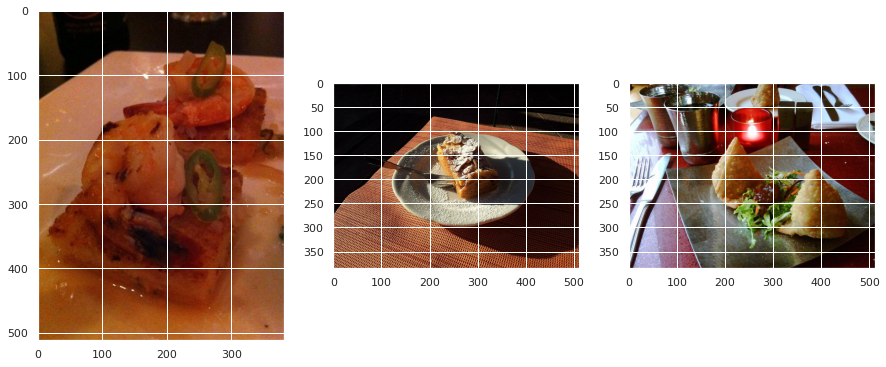

In [5]:
plot_image(train+'/food/')

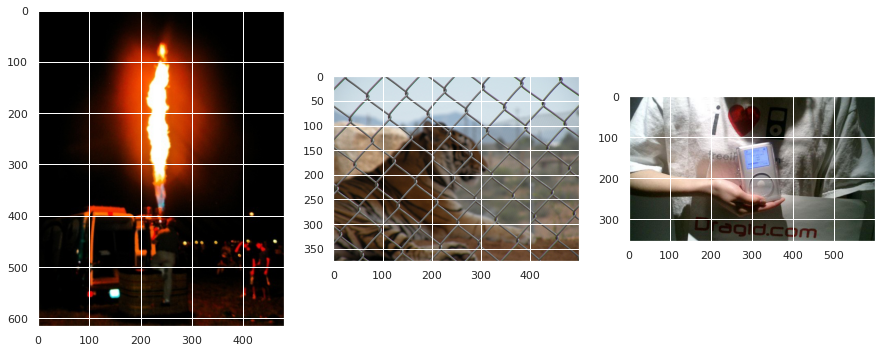

In [6]:
plot_image(train+'/nonfood/')

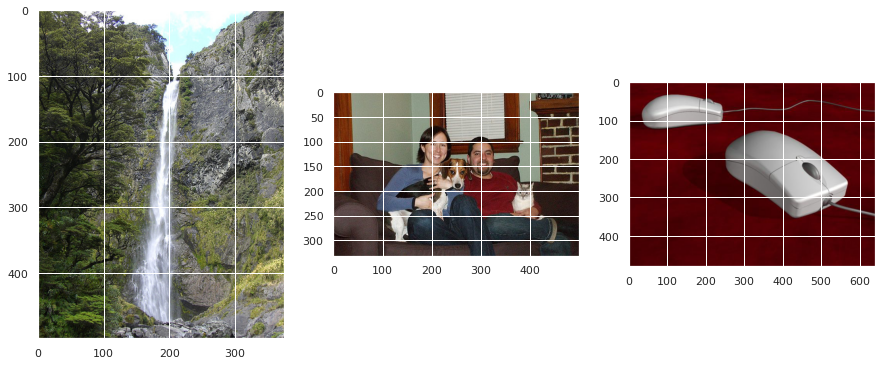

In [7]:
plot_image(validation+'/nonfood/')

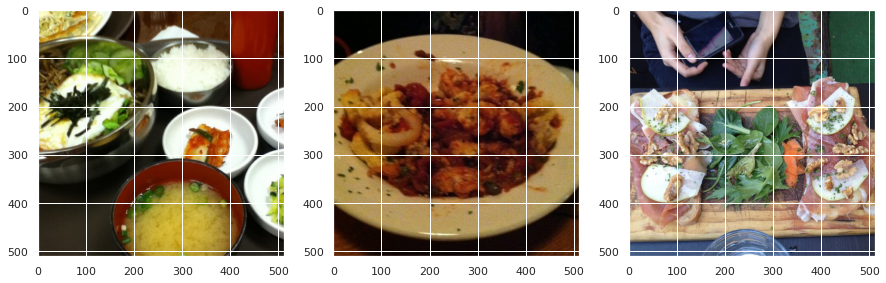

In [8]:
plot_image(validation+'/food/')

In [9]:
# define parameters
image_size = (124,124,3)
batch_size = 128

# create image data generator
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create image generator
train_generator = train_data_gen.flow_from_directory(train,target_size=image_size[:-1],batch_size=batch_size,class_mode='binary',)
valid_generator = train_data_gen.flow_from_directory(validation,target_size=image_size[:-1],batch_size=batch_size,class_mode='binary',)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# download pre trained model VGG 16
trained_model = VGG16(input_shape=image_size,weights='imagenet',include_top=False)

# free layers of pre trained model
trained_model.trainable = False

In [11]:
trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 124, 124, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 124, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

In [12]:
# no of output nodes
n_output = len(os.listdir(train))

# build model
x = Flatten()(trained_model.output)

# create model
model = Model(trained_model.input,x)

In [13]:
# get output shape of the mode
input_shape =  [batch_size]+list(image_size)
output_shape = model.compute_output_shape(input_shape)
output_shape

TensorShape([128, 4608])

In [14]:
# create arrays for storing bottleneck features of train, test,and valid
n_train = len(train_food) + len(train_nonfood)
n_valid = len(val_food) + len(val_nonfood)
n_test = len(test_all)

x_train = np.zeros((n_train,output_shape[1]))
y_train = np.zeros(n_train)

x_valid = np.zeros((n_valid,output_shape[1]))
y_valid = np.zeros((n_valid))

x_test = np.zeros((n_test,output_shape[1]))

In [15]:
# extract bottleneck features for training
steps = 0
for images,label in train_generator:
  features = model.predict(images)
  
  # check size of batch as in the end if may be less than actual batch size
  size = len(label)

  # update arrays
  x_train[steps:steps+size] = features
  y_train[steps:steps+size] = label

  # increase steps
  steps = steps + size

  # if all images are done then break
  if steps >= n_train:
    break

In [16]:
# extract bottleneck features for validation
steps = 0
for images,label in valid_generator:
  features = model.predict(images)
  
  # check size of batch as in the end if may be less than actual batch size
  size = len(label)

  # update arrays
  x_valid[steps:steps+size] = features
  y_valid[steps:steps+size] = label

  # increase steps
  steps = steps + size

  # if all images are done then break
  if steps >= n_valid:
    break

In [17]:
# checking for max and min
x_train.max(), x_train.min()

(658.8712768554688, 0.0)

In [18]:
# scaling the train and valid input
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

In [19]:
# Logistic Regression Model in Tensorflow
i = Input(shape=(x_train.shape[1],))
x = Dense(1,activation='sigmoid')(i)

# define classification model
linear_model = Model(i,x)

#compile
linear_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
# train the model
hist = linear_model.fit(x_train,y_train,batch_size=batch_size,epochs=10,validation_data=(x_valid,y_valid))

Epoch 1/10
24/24 [==============================] - 0s 14ms/step - loss: 0.2768 - accuracy: 0.8857 - val_loss: 0.1060 - val_accuracy: 0.9620
Epoch 2/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0863 - accuracy: 0.9720 - val_loss: 0.0830 - val_accuracy: 0.9710
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0527 - accuracy: 0.9850 - val_loss: 0.0798 - val_accuracy: 0.9680
Epoch 4/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0368 - accuracy: 0.9923 - val_loss: 0.0784 - val_accuracy: 0.9720
Epoch 5/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9977 - val_loss: 0.0780 - val_accuracy: 0.9680
Epoch 6/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9987 - val_loss: 0.0767 - val_accuracy: 0.9690
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9997 - val_loss: 0.0763 - val_accuracy: 0.9690
Epoch 8/10
24/24 [

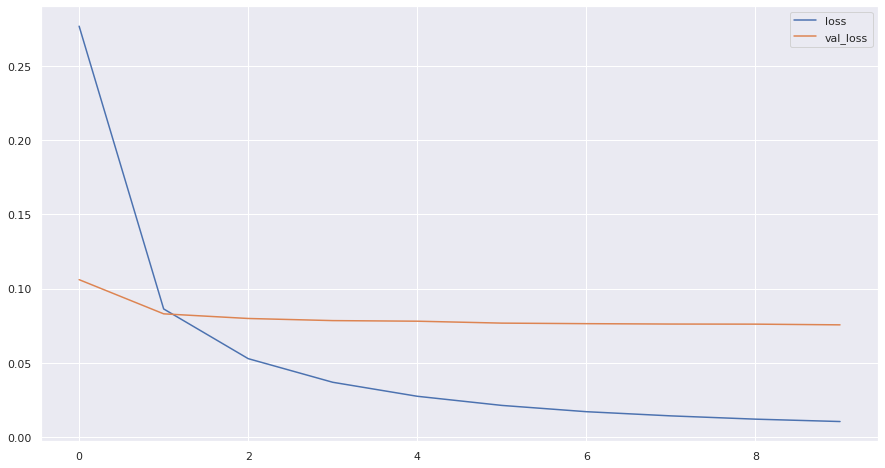

In [21]:
# plot loss 
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

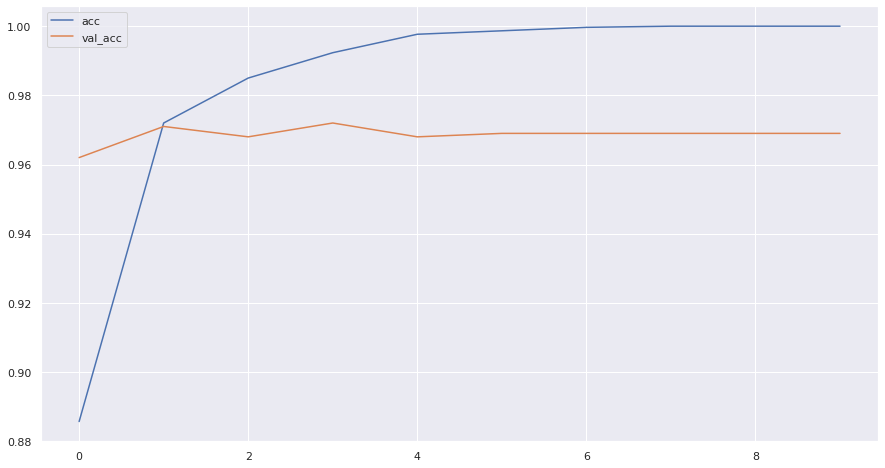

In [22]:
# Plot  accuracy 
plt.figure(figsize=(15,8))
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()

In [23]:
# data gen
test_folder = 'data/test'

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create image generator
test_generator = test_data_gen.flow_from_directory(test_folder,target_size=image_size[:-1],batch_size=batch_size,class_mode='binary')

Found 1000 images belonging to 1 classes.


In [24]:
# extract bottleneck features for validation
steps = 0
for images,label in test_generator:
  features = model.predict(images)
  
  # check size of batch as in the end if may be less than actual batch size
  size = len(label)

  # update arrays
  x_test[steps:steps+size] = features

  # increase steps
  steps = steps + size

  # if all images are done then break
  if steps >= n_test:
    break

In [25]:
# scaling test data
x_test = scaler.transform(x_test)
predict = linear_model.predict(x_test)

In [26]:
df = pd.DataFrame((predict > 0.5).astype(int).flatten(),columns=['predict'])
cat_map = {v: k for k, v in train_generator.class_indices.items()}
df['predict'] = df['predict'].map(cat_map)
df['filenames'] = test_generator.filenames
df.sample(4)

,predict,filenames
958,food,images/1_61.jpg
953,nonfood,images/1_57.jpg
371,nonfood,images/0_432.jpg
629,nonfood,images/1_214.jpg


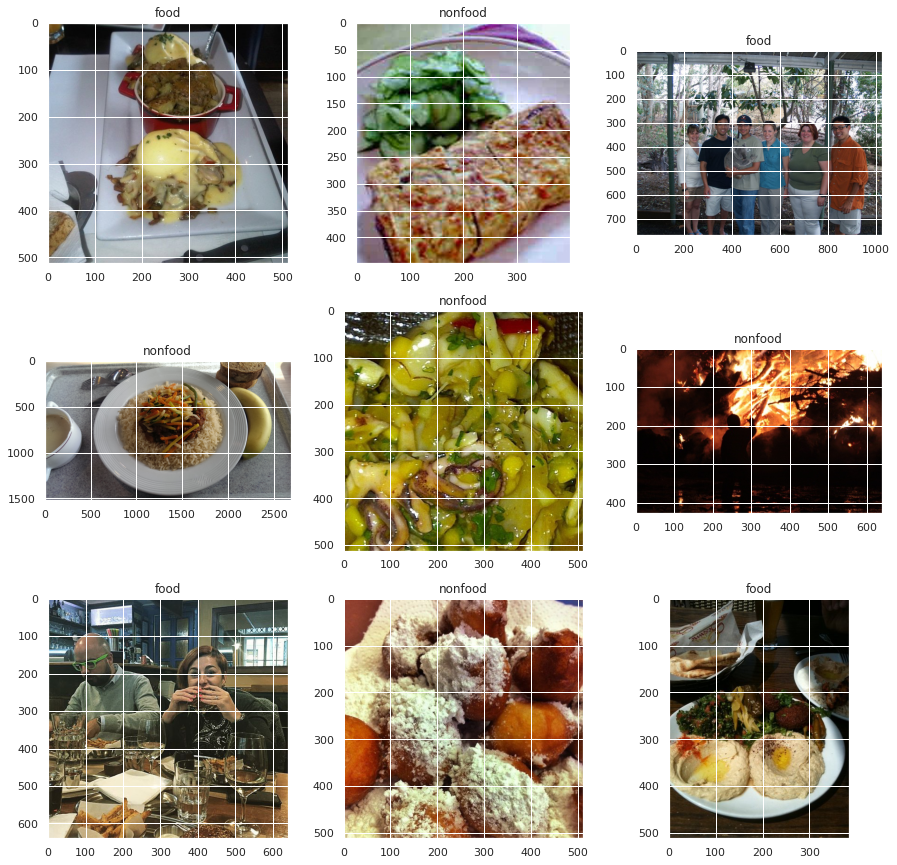

In [27]:
sample = df.sample(9)
filename = sample['filenames'].tolist()
label = sample['predict'].tolist()
fig, axs = plt.subplots(3, 3,figsize=(15, 15))
pos = 0
for row in range(3):
  for col in range(3):
      filepath= test_folder + "/"+filename[pos]
      axs[row,col].imshow(image.load_img(filepath))
      axs[row,col].set_title(label[pos])
      pos = pos + 1